In [53]:
# label and scale images (hists and boxplots)

# Problem Statement

---

*In this project I am assuming the role of a data scientist at Zillow*

**Zillow** is an American tech real-estate marketplace. **Our website advertises home and rental units** for property owners and managers. These advertisement services are one the company's primary source of income.

One feature that **Zillow** is known for is that it **provides free public estimates on the value of any home**. In this project, **we use data on home sales in Ames, Iowa** and create several linear regression models that **attempt to predict the sale price of a home** based on some of its information (size in square feet, number of fireplaces, neighborhood, etc). The value of having stronger price predictions is to improve public perception of Zillow and its reliability, ultimately increasing the number of users willing to purchase advertisement on our website.

We will deem our project successful if our model predicts sale prices of unseen data well. More precisely, **we will call our model succesful if the R squared score is above 0.75**.


# Cleaning and Feature Engineering

---

## Imports and Functions

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# to remove
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

In [3]:
def qual_to_num(data, feature):
    '''
    Takes in DataFrame and column name containing string ratings
    replaces the ratings with numerical values
    
    Returns the updated DataFrame
    '''
    
    # ratings that appear in the dataset
    # and corresponding numerical value
    qual_conversion = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0, np.nan: 0}
    
    # convert to ratings using dictionary
    data[feature] = data[feature].apply(lambda x: qual_conversion[x])
    
    return data

---

## Dealing with Missing Values

In [4]:
raw_housing = pd.read_csv('../datasets/train.csv')
raw_housing.shape

(2051, 81)

Cleaning 81 features is a massive task. After reading through the [data description](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt), I have hand picked a much more manageable 32 variables that I believe will have the most relevance for predicting home saleprices. I tried to be lax in my choices so that many can be genuinely ruled out through objective data analysis.

In [5]:
init_features = ['MS Zoning', 'Lot Area', 'Land Contour', 'Land Slope', 'Neighborhood', 'Condition 1',
            'Bldg Type', 'House Style', 'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add',
           'Mas Vnr Type', 'Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond',
           'Garage Area', 'Wood Deck SF', 'Open Porch SF', 'Kitchen Qual', 'Bedroom AbvGr',
           'Full Bath', 'Half Bath', 'Fireplaces', 'Fireplace Qu', 'BsmtFin SF 1', 'Bsmt Unf SF', '1st Flr SF', '2nd Flr SF', 'Sale Type', 'SalePrice']

In [6]:
house = raw_housing[init_features].copy()
house.head()

,MS Zoning,Lot Area,Land Contour,Land Slope,Neighborhood,Condition 1,Bldg Type,House Style,Overall Qual,Overall Cond,...,Full Bath,Half Bath,Fireplaces,Fireplace Qu,BsmtFin SF 1,Bsmt Unf SF,1st Flr SF,2nd Flr SF,Sale Type,SalePrice
0,RL,13517,Lvl,Gtl,Sawyer,RRAe,1Fam,2Story,6,8,...,2,1,0,NaN,533.0,192.0,725,754,WD,130500
1,RL,11492,Lvl,Gtl,SawyerW,Norm,1Fam,2Story,7,5,...,2,1,1,TA,637.0,276.0,913,1209,WD,220000
2,RL,7922,Lvl,Gtl,NAmes,Norm,1Fam,1Story,5,7,...,1,0,0,NaN,731.0,326.0,1057,0,WD,109000
3,RL,9802,Lvl,Gtl,Timber,Norm,1Fam,2Story,5,5,...,2,1,0,NaN,0.0,384.0,744,700,WD,174000
4,RL,14235,Lvl,Gtl,SawyerW,Norm,1Fam,1.5Fin,6,8,...,2,0,0,NaN,0.0,676.0,831,614,WD,138500


Let us begin our data cleaning by making the columns easier to work with and more Pythonic.

In [7]:
house.columns = [col.lower().replace(' ','_').replace('/','_') for col in house.columns]

In [8]:
house.head()

,ms_zoning,lot_area,land_contour,land_slope,neighborhood,condition_1,bldg_type,house_style,overall_qual,overall_cond,...,full_bath,half_bath,fireplaces,fireplace_qu,bsmtfin_sf_1,bsmt_unf_sf,1st_flr_sf,2nd_flr_sf,sale_type,saleprice
0,RL,13517,Lvl,Gtl,Sawyer,RRAe,1Fam,2Story,6,8,...,2,1,0,NaN,533.0,192.0,725,754,WD,130500
1,RL,11492,Lvl,Gtl,SawyerW,Norm,1Fam,2Story,7,5,...,2,1,1,TA,637.0,276.0,913,1209,WD,220000
2,RL,7922,Lvl,Gtl,NAmes,Norm,1Fam,1Story,5,7,...,1,0,0,NaN,731.0,326.0,1057,0,WD,109000
3,RL,9802,Lvl,Gtl,Timber,Norm,1Fam,2Story,5,5,...,2,1,0,NaN,0.0,384.0,744,700,WD,174000
4,RL,14235,Lvl,Gtl,SawyerW,Norm,1Fam,1.5Fin,6,8,...,2,0,0,NaN,0.0,676.0,831,614,WD,138500


Our first major task is to deal with the missing values in the dataset. When we check which columns have missing values, we see that some columns have identical counts. Let us start by seeing if these counts appear in the same observations.

In [9]:
house.isnull().sum()

ms_zoning            0
lot_area             0
land_contour         0
land_slope           0
neighborhood         0
condition_1          0
bldg_type            0
house_style          0
overall_qual         0
overall_cond         0
year_built           0
year_remod_add       0
mas_vnr_type        22
exter_qual           0
exter_cond           0
bsmt_qual           55
bsmt_cond           55
garage_area          1
wood_deck_sf         0
open_porch_sf        0
kitchen_qual         0
bedroom_abvgr        0
full_bath            0
half_bath            0
fireplaces           0
fireplace_qu      1000
bsmtfin_sf_1         1
bsmt_unf_sf          1
1st_flr_sf           0
2nd_flr_sf           0
sale_type            0
saleprice            0
dtype: int64

Below we see that there is one row missing all the basement data. It may be fair to assume that the home is missing a basement and these values would all be zero.

In [10]:
null_basement_info = house[house['bsmtfin_sf_1'].isna()]
null_basement_info[['bsmt_qual', 'bsmt_cond', 'garage_area', 'bsmtfin_sf_1', 'bsmt_unf_sf']]

,bsmt_qual,bsmt_cond,garage_area,bsmtfin_sf_1,bsmt_unf_sf
1327,NaN,NaN,280.0,NaN,NaN


In [11]:
# turn missing basement square feet info into zeros
# basement quality and condition will be dealt with later
house.loc[house['bsmtfin_sf_1'].isna(), ['bsmtfin_sf_1', 'bsmt_unf_sf']] = 0

We only have one garage related column so it is more challenging to infer about the row with a missing `garage_area` value. It is likely fine to convert this singe row's `garage_area` value to zero also.

In [12]:
house.loc[house['garage_area'].isna(), 'garage_area'] = 0

Missing values in the basement columns appear to be homes without basements. We see the missing 55 entries in the same rows for `bsmt_qual` and `bsmt_cond`.

In [13]:
# takes the data that is missing bsmt_qual and checks what the bsmt_cond are
house.loc[house['bsmt_qual'].isnull(), 'bsmt_cond'].value_counts(dropna = False)

NaN    55
Name: bsmt_cond, dtype: int64

In [14]:
# converts descriptive rating to numerical
house = qual_to_num(house, 'bsmt_qual')
house = qual_to_num(house, 'bsmt_cond')

We see the same issue arise with `fireplaces` and `fireplace_qu`. The homes with zero fireplaces are fittingly missing descriptions for the quality of their fireplace.

In [15]:
# homes with 0 fireplaces are have NaN fireplace_qu values
house.loc[house['fireplaces'] == 0, 'fireplace_qu'].value_counts(dropna = False)

NaN    1000
Name: fireplace_qu, dtype: int64

In [16]:
# converts descriptive rating to numerical
house = qual_to_num(house, 'fireplace_qu')

The only remaining column with missing entires is `mas_vnr_typ`. Below we see that 'None' is the most frequent value in the column. With only 22 missing values, it seems like it will not be harmful to replace the missing values with 'None'

In [17]:
house.isnull().sum()

ms_zoning          0
lot_area           0
land_contour       0
land_slope         0
neighborhood       0
condition_1        0
bldg_type          0
house_style        0
overall_qual       0
overall_cond       0
year_built         0
year_remod_add     0
mas_vnr_type      22
exter_qual         0
exter_cond         0
bsmt_qual          0
bsmt_cond          0
garage_area        0
wood_deck_sf       0
open_porch_sf      0
kitchen_qual       0
bedroom_abvgr      0
full_bath          0
half_bath          0
fireplaces         0
fireplace_qu       0
bsmtfin_sf_1       0
bsmt_unf_sf        0
1st_flr_sf         0
2nd_flr_sf         0
sale_type          0
saleprice          0
dtype: int64

In [18]:
house['mas_vnr_type'].value_counts(dropna = False)

None       1218
BrkFace     630
Stone       168
NaN          22
BrkCmn       13
Name: mas_vnr_type, dtype: int64

In [19]:
house.loc[house['mas_vnr_type'].isna(), 'mas_vnr_type'] = 'None'

---

## Feature Engineering

Many aspects of the homes have two ratings in the dataset called condition and quality. Let us convert these scores to numeric values and take their product, that way homes which features that score well in both quality and condition are marked with a notibly higher score.

In [20]:
# convert descriptive rating to numerical
house = qual_to_num(house, 'kitchen_qual')
house = qual_to_num(house,'exter_qual')
house = qual_to_num(house, 'exter_cond')

In [21]:
# combines pairs of overall quality and condition columns into a single column via multiplication
house['qual_cond'] = house['overall_qual'] * house['overall_cond']
house.drop(columns = ['overall_qual', 'overall_cond'], inplace = True)

house['exter_qual_cond'] = house['exter_qual'] * house['exter_cond']
house.drop(columns = ['exter_qual', 'exter_cond'], inplace = True)

house['bsmt_qual_cond'] = house['bsmt_qual'] * house['bsmt_cond']
house.drop(columns = ['bsmt_qual', 'bsmt_cond'], inplace = True)

Fireplaces have a count column and a quality column. To note homes with a large number of high quality fireplaces, let us again from a new column by taking the product of the two.

In [22]:
# combines fireplace count and quality rating via multiplication
house['fireplaces_weighted'] = house['fireplaces'] * house['fireplace_qu']
house.drop(columns = ['fireplaces', 'fireplace_qu'], inplace = True)

Above basement living area seems like a very important feature. Let us build this column by summing the values of the first floor and second floor areas.

In [23]:
house['sq_ft'] = house['1st_flr_sf'] + house['2nd_flr_sf']
house.drop(columns = ['1st_flr_sf', '2nd_flr_sf'], inplace = True)

Basement area also seems important for predicting home prices. It seems fair to expect that finished basements are more relevant than unfinished basements. Let us sum the areas of the two but only weight unfinished basements at half their amount.

In [24]:
# adds square feet (SF) measurements with weights:
# 1*(Finished SF) + 0.5(Unfinished SF)
house['bsmt_weighted_sf'] = house['bsmtfin_sf_1'] + 0.5*house['bsmt_unf_sf']
house.drop(columns = ['bsmtfin_sf_1', 'bsmt_unf_sf'], inplace = True)

The number of baths is a common count brought up with home value. Let us sum full and half bath counts together.

In [25]:
# combines full bath and half bath into one column
house['bath'] = house['full_bath'] + 0.5*house['half_bath']
house.drop(columns = ['full_bath', 'half_bath'], inplace = True)

---

## Removing Outliers

In [26]:
house.describe()

,lot_area,year_built,year_remod_add,garage_area,wood_deck_sf,open_porch_sf,kitchen_qual,bedroom_abvgr,saleprice,qual_cond,exter_qual_cond,bsmt_qual_cond,fireplaces_weighted,sq_ft,bsmt_weighted_sf,bath
count,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000
mean,10065.208191,1971.708922,1984.190151,473.440761,93.833740,47.556802,3.517309,2.843491,181469.701609,33.866407,10.518284,10.549000,2.033642,1493.817162,725.810580,1.762799
std,6742.488909,30.177889,21.036250,216.135102,128.549416,66.747241,0.665577,0.826618,79258.659352,9.255859,2.195124,3.061151,2.283203,497.618666,406.466601,0.637775
min,1300.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,2.000000,0.000000,12789.000000,1.000000,2.000000,0.000000,0.000000,334.000000,0.000000,0.000000
25%,7500.000000,1953.500000,1964.500000,319.000000,0.000000,0.000000,3.000000,2.000000,129825.000000,30.000000,9.000000,9.000000,0.000000,1124.500000,440.250000,1.000000
50%,9430.000000,1974.000000,1993.000000,480.000000,0.000000,27.000000,3.000000,3.000000,162500.000000,35.000000,9.000000,12.000000,1.000000,1440.000000,674.500000,2.000000
75%,11513.500000,2001.000000,2004.000000,576.000000,168.000000,70.000000,4.000000,3.000000,214000.000000,40.000000,12.000000,12.000000,4.000000,1728.000000,916.750000,2.500000
max,159000.000000,2010.000000,2010.000000,1418.000000,1424.000000,547.000000,5.000000,8.000000,611657.000000,90.000000,25.000000,20.000000,12.000000,5642.000000,5877.000000,5.000000


The first thing that stands out in our summary statistics is the massive gap between the maximum `lot_area` and the 75th percentile. A full list of columns with questionable max values are:

- `lot_area`
- `wood_deck_sf`
- `open_porch_sf`
- `sale_price`
- `sq_ft`
- and `bsmt_weighted_sf`

Another interesting statistic is the minimum `year_built` is so much lower than the 25th percentile.

Let us investigate the distributions of these columns and remove any outliers that are very distant from the rest of the data.

#### Lot Area

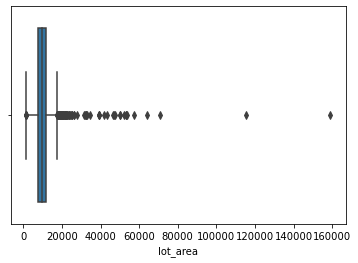

In [27]:
sns.boxplot(x = house['lot_area']);

In [28]:
perc_25 = house['lot_area'].quantile(0.25)
perc_75 = house['lot_area'].quantile(0.75)
large_lot = house[house['lot_area'] > perc_75]

In [29]:
large_lot['lot_area'].value_counts(bins = 25).sort_index()

(11367.514, 17414.4]    424
(17414.4, 23313.8]       55
(23313.8, 29213.2]        9
(29213.2, 35112.6]        6
(35112.6, 41012.0]        3
(41012.0, 46911.4]        3
(46911.4, 52810.8]        5
(52810.8, 58710.2]        4
(58710.2, 64609.6]        1
(64609.6, 70509.0]        0
(70509.0, 76408.4]        1
(76408.4, 82307.8]        0
(82307.8, 88207.2]        0
(88207.2, 94106.6]        0
(94106.6, 100006.0]       0
(100006.0, 105905.4]      0
(105905.4, 111804.8]      0
(111804.8, 117704.2]      1
(117704.2, 123603.6]      0
(123603.6, 129503.0]      0
(129503.0, 135402.4]      0
(135402.4, 141301.8]      0
(141301.8, 147201.2]      0
(147201.2, 153100.6]      0
(153100.6, 159000.0]      1
Name: lot_area, dtype: int64

We see a significant drop off in number of homes containing more than 77,000 square feet of lot area. Let us trim off these outliers.

In [30]:
# consider homes with less than 77,000 lot_area
house = house[house['lot_area'] <= 77_000]

#### Wood Deck

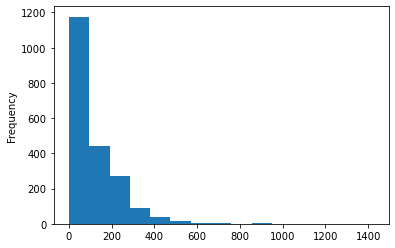

In [31]:
house['wood_deck_sf'].plot.hist(bins = 15);

In [32]:
house['wood_deck_sf'].value_counts(bins = 15).sort_index()

(-1.4249999999999998, 94.933]    1176
(94.933, 189.867]                 441
(189.867, 284.8]                  274
(284.8, 379.733]                   89
(379.733, 474.667]                 39
(474.667, 569.6]                   16
(569.6, 664.533]                    7
(664.533, 759.467]                  4
(759.467, 854.4]                    0
(854.4, 949.333]                    2
(949.333, 1044.267]                 0
(1044.267, 1139.2]                  0
(1139.2, 1234.133]                  0
(1234.133, 1329.067]                0
(1329.067, 1424.0]                  1
Name: wood_deck_sf, dtype: int64

There is three homes with wood decks significantly larger than the rest. Let us drop them.

In [33]:
house = house[house['wood_deck_sf'] < 760]

#### Open Porch

In [34]:
house['open_porch_sf'].value_counts(bins = 15).sort_index()

(-0.548, 36.467]      1178
(36.467, 72.933]       378
(72.933, 109.4]        197
(109.4, 145.867]       122
(145.867, 182.333]      69
(182.333, 218.8]        42
(218.8, 255.267]        27
(255.267, 291.733]      13
(291.733, 328.2]         9
(328.2, 364.667]         2
(364.667, 401.133]       3
(401.133, 437.6]         1
(437.6, 474.067]         1
(474.067, 510.533]       2
(510.533, 547.0]         2
Name: open_porch_sf, dtype: int64

Although there are a few homes with very large open porches, they do not appear to stand out too far from the rest of the data.

#### Square Feet

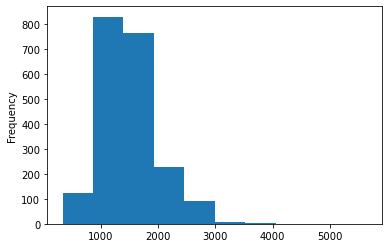

In [35]:
house['sq_ft'].plot.hist();

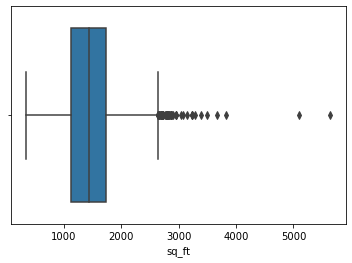

In [36]:
sns.boxplot(x = house['sq_ft']);

In [37]:
house['sq_ft'].value_counts(bins = 20).sort_index()

(328.69100000000003, 599.4]      9
(599.4, 864.8]                 113
(864.8, 1130.2]                401
(1130.2, 1395.6]               428
(1395.6, 1661.0]               475
(1661.0, 1926.4]               288
(1926.4, 2191.8]               146
(2191.8, 2457.2]                81
(2457.2, 2722.6]                66
(2722.6, 2988.0]                26
(2988.0, 3253.4]                 6
(3253.4, 3518.8]                 3
(3518.8, 3784.2]                 1
(3784.2, 4049.6]                 1
(4049.6, 4315.0]                 0
(4315.0, 4580.4]                 0
(4580.4, 4845.8]                 0
(4845.8, 5111.2]                 1
(5111.2, 5376.6]                 0
(5376.6, 5642.0]                 1
Name: sq_ft, dtype: int64

We see two homes with substantially more living space than others. Let us drop these observations.

In [38]:
house = house[house['sq_ft'] < 4050]

#### Sale Price

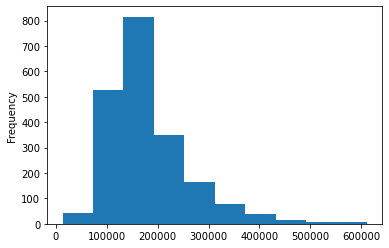

In [39]:
house['saleprice'].plot.hist();

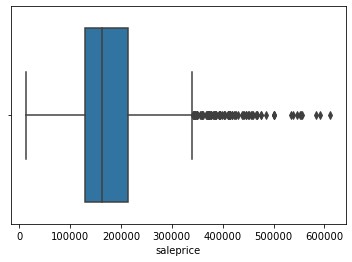

In [40]:
sns.boxplot(x = house['saleprice']);

In [41]:
house['saleprice'].value_counts(bins = 15).sort_index()

(12190.131, 52713.533]       15
(52713.533, 92638.067]      109
(92638.067, 132562.6]       443
(132562.6, 172487.133]      567
(172487.133, 212411.667]    383
(212411.667, 252336.2]      215
(252336.2, 292260.733]      130
(292260.733, 332185.267]     75
(332185.267, 372109.8]       40
(372109.8, 412034.333]       28
(412034.333, 451958.867]     18
(451958.867, 491883.4]        9
(491883.4, 531807.933]        3
(531807.933, 571732.467]      6
(571732.467, 611657.0]        3
Name: saleprice, dtype: int64

Nothing in the above boxplot really suggests we need to remove any data due to their sale price. Let us move on.

#### Weighted Basement Square Feet

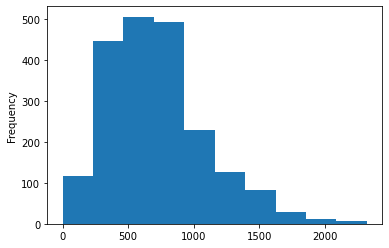

In [42]:
house['bsmt_weighted_sf'].plot.hist();

In [43]:
house['bsmt_weighted_sf'].value_counts(bins = 20)

(347.85, 463.8]      292
(579.75, 695.7]      261
(695.7, 811.65]      260
(463.8, 579.75]      244
(811.65, 927.6]      231
(231.9, 347.85]      154
(927.6, 1043.55]     125
(1043.55, 1159.5]    104
(1159.5, 1275.45]     72
(-2.32, 115.95]       68
(1275.45, 1391.4]     54
(115.95, 231.9]       49
(1391.4, 1507.35]     48
(1507.35, 1623.3]     35
(1623.3, 1739.25]     21
(1739.25, 1855.2]      7
(1855.2, 1971.15]      7
(2203.05, 2319.0]      5
(1971.15, 2087.1]      4
(2087.1, 2203.05]      3
Name: bsmt_weighted_sf, dtype: int64

The weighted basement size column also appears fine as is.

#### Year Built

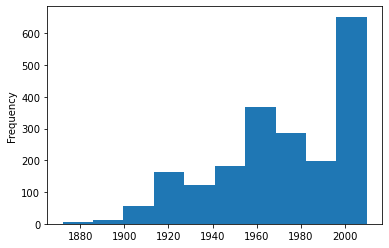

In [44]:
house['year_built'].plot.hist(bins = 10);

In [45]:
house['year_built'].value_counts(bins = 10).sort_index()

(1871.861, 1885.8]      7
(1885.8, 1899.6]       12
(1899.6, 1913.4]       56
(1913.4, 1927.2]      162
(1927.2, 1941.0]      139
(1941.0, 1954.8]      165
(1954.8, 1968.6]      369
(1968.6, 1982.4]      285
(1982.4, 1996.2]      197
(1996.2, 2010.0]      652
Name: year_built, dtype: int64

It does not seem necessary to drop homes built especially long ago. These homes to not appear to have extraordinary sale prices.

In [46]:
house.loc[house['year_built'] < 1900, ['year_built', 'saleprice']].sort_values(by = 'year_built')

,year_built,saleprice
951,1872,122000
136,1875,94000
1134,1879,185000
12,1880,131000
784,1880,117500
1939,1880,295000
394,1885,122500
501,1890,78500
175,1890,184000
1204,1890,95000


The sale price does not seem to have any outlandish values based on the year built. Below we see that these older homes typically have less value, though not by much, but this seems appropriate.

In [47]:
house.loc[house['year_built'] < 1900, 'saleprice'].mean()

159033.57894736843

In [48]:
house['saleprice'].mean()

181073.38943248533

#### Bedroom Count

In [49]:
house['bedroom_abvgr'].value_counts().sort_index()

0       4
1      75
2     542
3    1106
4     263
5      41
6      12
8       1
Name: bedroom_abvgr, dtype: int64

---

## Light Analysis

In [ ]:

# can answer question problem statement?

---

## Saving The Cleaned Dataset as '*cleaned_train.csv*'

In [50]:
house.to_csv('../datasets/cleaned_train.csv', index = False)